In [1]:
from pathlib import Path

import numpy as np
import torch

from tqdm.auto import tqdm
from tqdm.notebook import tqdm_notebook, trange

import itertools

import os
from dotenv import find_dotenv, load_dotenv

load_dotenv(find_dotenv(), verbose=True)

True

In [2]:
debug = True

# prepare data

In [3]:
mask_img = 'config/reliable_voxel_mask.nii'

In [4]:
voxel_masks = np.load('config/voxel_masks.npy')

# plot brain for selected models, and searchlight

In [5]:
def save_fig(vertex_data, path, with_rois=True, with_labels=True, with_sulci=True):
    fig = cortex.quickflat.make_figure(vertex_data,
                                   with_curvature=False,
                                   with_rois=with_rois,
                                   with_labels=with_labels,
                                   with_sulci=with_sulci,
                                   with_colorbar=False,)
    # Add sulci in light yellow
    _ = cortex.quickflat.composite.add_sulci(fig, vertex_data,
                                             with_labels=with_labels,)
    # Add all rois, with a particular color scheme:
    # _ = cortex.quickflat.composite.add_rois(fig, volume,
    #                                         with_labels=True,
    #                                         labelsize=1,)
    # # Highlight face- and body-selective ROIs:
    # _ = cortex.quickflat.composite.add_rois(fig, volume,
    #                                         roi_list=['FFA', 'EBA', 'OFA'],  # (This defaults to all rois if not specified)
    #                                         with_labels=True,
    #                                         linewidth=5,
    #                                         linecolor=(0.9, 0.5, 0.5),
    #                                         labelcolor=(0.9, 0.5, 0.5),
    #                                         labelsize=20,
    #                                         roifill=(0.9, 0.5, 0.5),
    #                                         fillalpha=0.35,
    #                                         dashes=(5, 3)                    # Dash length & gap btw dashes
    #                                         )
    plt.savefig(path, dpi=144)
    plt.close()

In [6]:
def get_searchlight(data1: np.array, data2: np.array, voxel_masks: np.array):
    half_window_size = 1  # 3x3
    # half_window_size = 2 # 5x5
    th_num_voxels = 3

    corrd_shape = voxel_masks.shape[1:]
    corrds = voxel_masks.sum(0).nonzero()

    voxel_data1 = np.zeros(shape=voxel_masks.shape)  # [num_subs, x, y, z]
    voxel_data1[voxel_masks == 1] = data1
    voxel_data2 = np.zeros(shape=voxel_masks.shape)  # [num_subs, x, y, z]
    voxel_data2[voxel_masks == 1] = data2

    searchlight_voxel_data = np.zeros(shape=corrd_shape)

    lens = []
    for corrd in zip(*corrds):

        # window corrdinates
        window_corrds = []
        for i, c in enumerate(corrd):
            start = c - half_window_size
            if start < 0: start = 0
            end = c + half_window_size
            if end > corrd_shape[i]: end = corrd_shape[i]
            window_corrds.append((start, end))

        window_voxels1 = voxel_data1[:,
                         window_corrds[0][0]:window_corrds[0][1],
                         window_corrds[1][0]:window_corrds[1][1],
                         window_corrds[2][0]:window_corrds[2][1], ]
        window_voxels1 = window_voxels1[window_voxels1.nonzero()]
        window_voxels2 = voxel_data2[:,
                         window_corrds[0][0]:window_corrds[0][1],
                         window_corrds[1][0]:window_corrds[1][1],
                         window_corrds[2][0]:window_corrds[2][1], ]
        window_voxels2 = window_voxels2[window_voxels2.nonzero()]

        assert len(window_voxels1) == len(window_voxels2)
        num_voxels = len(window_voxels1)
        if num_voxels < th_num_voxels: continue

        corr = np.corrcoef(window_voxels1, window_voxels2)[0, 1]

        searchlight_voxel_data[corrd] = corr

    return searchlight_voxel_data

In [7]:
from matplotlib import pyplot as plt
from nilearn import plotting
import pandas as pd
from src.utils.visulization import save_as_nii
from src.utils.metrics import vectorized_correlation

In [8]:
names = ['gt', 'Best']
mc_dict = {}
for name in names:
    mc_dict[name] = torch.load(f'tmp/notebook922/{name}-motion_correlation.pt')

In [9]:
gt_motion_correlation = mc_dict['gt']

best_model_motion_correlation = mc_dict['Best']

best_model_motion_cvorrelation_similarity = get_searchlight(best_model_motion_correlation, gt_motion_correlation,
                                                           voxel_masks)

In [10]:
mc_dict['searchlight'] = best_model_motion_cvorrelation_similarity

In [11]:
from src.utils.visulization import save_voxel_data_as_subject_mean_nii, save_as_nii

import numpy as np
from nilearn import surface
from nilearn import datasets
import cortex
import matplotlib.pyplot as plt
import os

In [13]:
for name, mc in mc_dict.items():

    voxel_score = mc

    tmp_nii_path = Path(f'tmp/notebook923/mc.nii')
    example_nii_path = Path('config/example.nii')
    
    if name != 'searchlight':
        save_voxel_data_as_subject_mean_nii(voxel_masks, voxel_score, example_nii_path, tmp_nii_path)
    else:
        save_as_nii(example_nii_path, tmp_nii_path, voxel_score)

    fill_nan_value = 0
    nii_path = str(tmp_nii_path)
    fsaverage = datasets.fetch_surf_fsaverage('fsaverage')

    texture = np.concatenate([surface.vol_to_surf(nii_path, fsaverage.pial_left, mask_img=mask_img),
                             surface.vol_to_surf(nii_path, fsaverage.pial_right, mask_img=mask_img)])
    texture[np.isnan(texture)] = fill_nan_value


    # This creates a Vertex object for our subject and test dataset
    vertex_data = cortex.Vertex(texture, 'fsaverage')

    vmax = 1
    vmin = -1

    vertex_data.vmax = vmax
    vertex_data.vmin = vmin

    cmap = 'seismic'
    vertex_data.cmap = cmap
    
    # print(name)
    
    # cortex.quickshow(vertex_data)
    
    # plt.show()
    save_fig(vertex_data, f'tmp/notebook923/{name}.png',
            with_rois=False, with_labels=False, with_sulci=False)

/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice


In [34]:
from src.utils.visulization import make_horizontal_color_bar

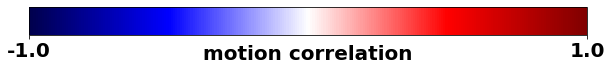

In [35]:
cbar_label_text = 'motion correlation'
cbar = make_horizontal_color_bar(cmap, vmax, vmin, cbar_label_text=cbar_label_text, offset=-0.7)
plt.savefig('tmp/notebook923/motion correlation cbar.pdf', bbox_inches="tight")
plt.show()

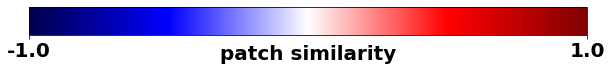

In [38]:
cbar_label_text = 'patch similarity'
cbar = make_horizontal_color_bar(cmap, vmax, vmin, cbar_label_text=cbar_label_text, offset=-0.7)
plt.savefig('tmp/notebook923/patch similarity cbar.pdf', bbox_inches="tight")
plt.show()

In [17]:
for i, (name, path) in enumerate(predictions_dict.items()):
    i += 1
    if path.name.endswith('.pt'):
        prediction = torch.load(path).float()
    else:
        prediction = torch.tensor(np.load(path)).float()

    prediction = prediction[:num_fmris]
    motion_correlation = get_motion_correlation(chaotic_motions[val_indices], prediction[val_indices])
    face_index = get_face_index(val_indices, prediction, yes_face_vid_idxs)

    # plot brain
    plot_warp(motion_correlation,
              os.path.join('figures', f'{i:04d} MOTION CORRELATION ^-^ {name}.jpg'),
              # vmax=0.3
              )
    plot_warp(face_index,
              os.path.join('figures', f'{i:04d} FACE INDEX ^-^ {name}.jpg'),
              # vmax=0.12
              )
    # plot_warp(motion_correlation)
    # plot_warp(face_index)

    if name != gt_name:

        # searchlight compare to ground truth
        motion_correlation_similarity = get_searchlight(motion_correlation, gt_motion_correlation, voxel_masks)
        face_index_similarity = get_searchlight(face_index, gt_face_index, voxel_masks)
        plot_warp(motion_correlation_similarity,
                  os.path.join('figures', f'{i + 10:04d} MOTION CORRELATION SEARCHLIGHT TO GROUNDTRUTH ^-^ {name}.jpg'),
                  vmax=1.)
        plot_warp(face_index_similarity,
                  os.path.join('figures', f'{i + 10:04d} FACE INDEX SEARCHLIGHT TO GROUNDTRUTH ^-^ {name}.jpg'),
                  vmax=1.)
        # plot_warp(motion_correlation_similarity)
        # plot_warp(face_index_similarity)

        if name != best_model_name:
            # diff to best model
            motion_correlation_similarity_diff = best_model_motion_correlation_similarity - motion_correlation_similarity
            face_index_similarity_diff = best_model_face_index_similarity - face_index_similarity
            plot_warp(motion_correlation_similarity_diff, os.path.join('figures',
                                                                       f'{i + 100:04d} MOTION CORRELATION SEARCHLIGHT TO GROUNDTRUTH DIFF TO BEST ^-^ {name}.jpg'),
                      vmax=0.5)
            plot_warp(face_index_similarity_diff, os.path.join('figures',
                                                               f'{i + 100:04d} FACE INDEX SEARCHLIGHT TO GROUNDTRUTH DIFF TO BEST ^-^ {name}.jpg'),
                      vmax=0.5)
            # plot_warp(motion_correlation_similarity_diff)
            # plot_warp(face_index_similarity_diff)

/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


axes:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


axes:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


axes:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


axes:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


axes:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


axes:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


axes:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


axes:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


axes:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


axes:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


axes:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


axes:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


axes:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


axes:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


axes:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


axes:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


axes:   0%|          | 0/12 [00:00<?, ?it/s]

/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/usr/local/anaconda3/envs/env_ube/lib/python3.8/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


axes:   0%|          | 0/12 [00:00<?, ?it/s]

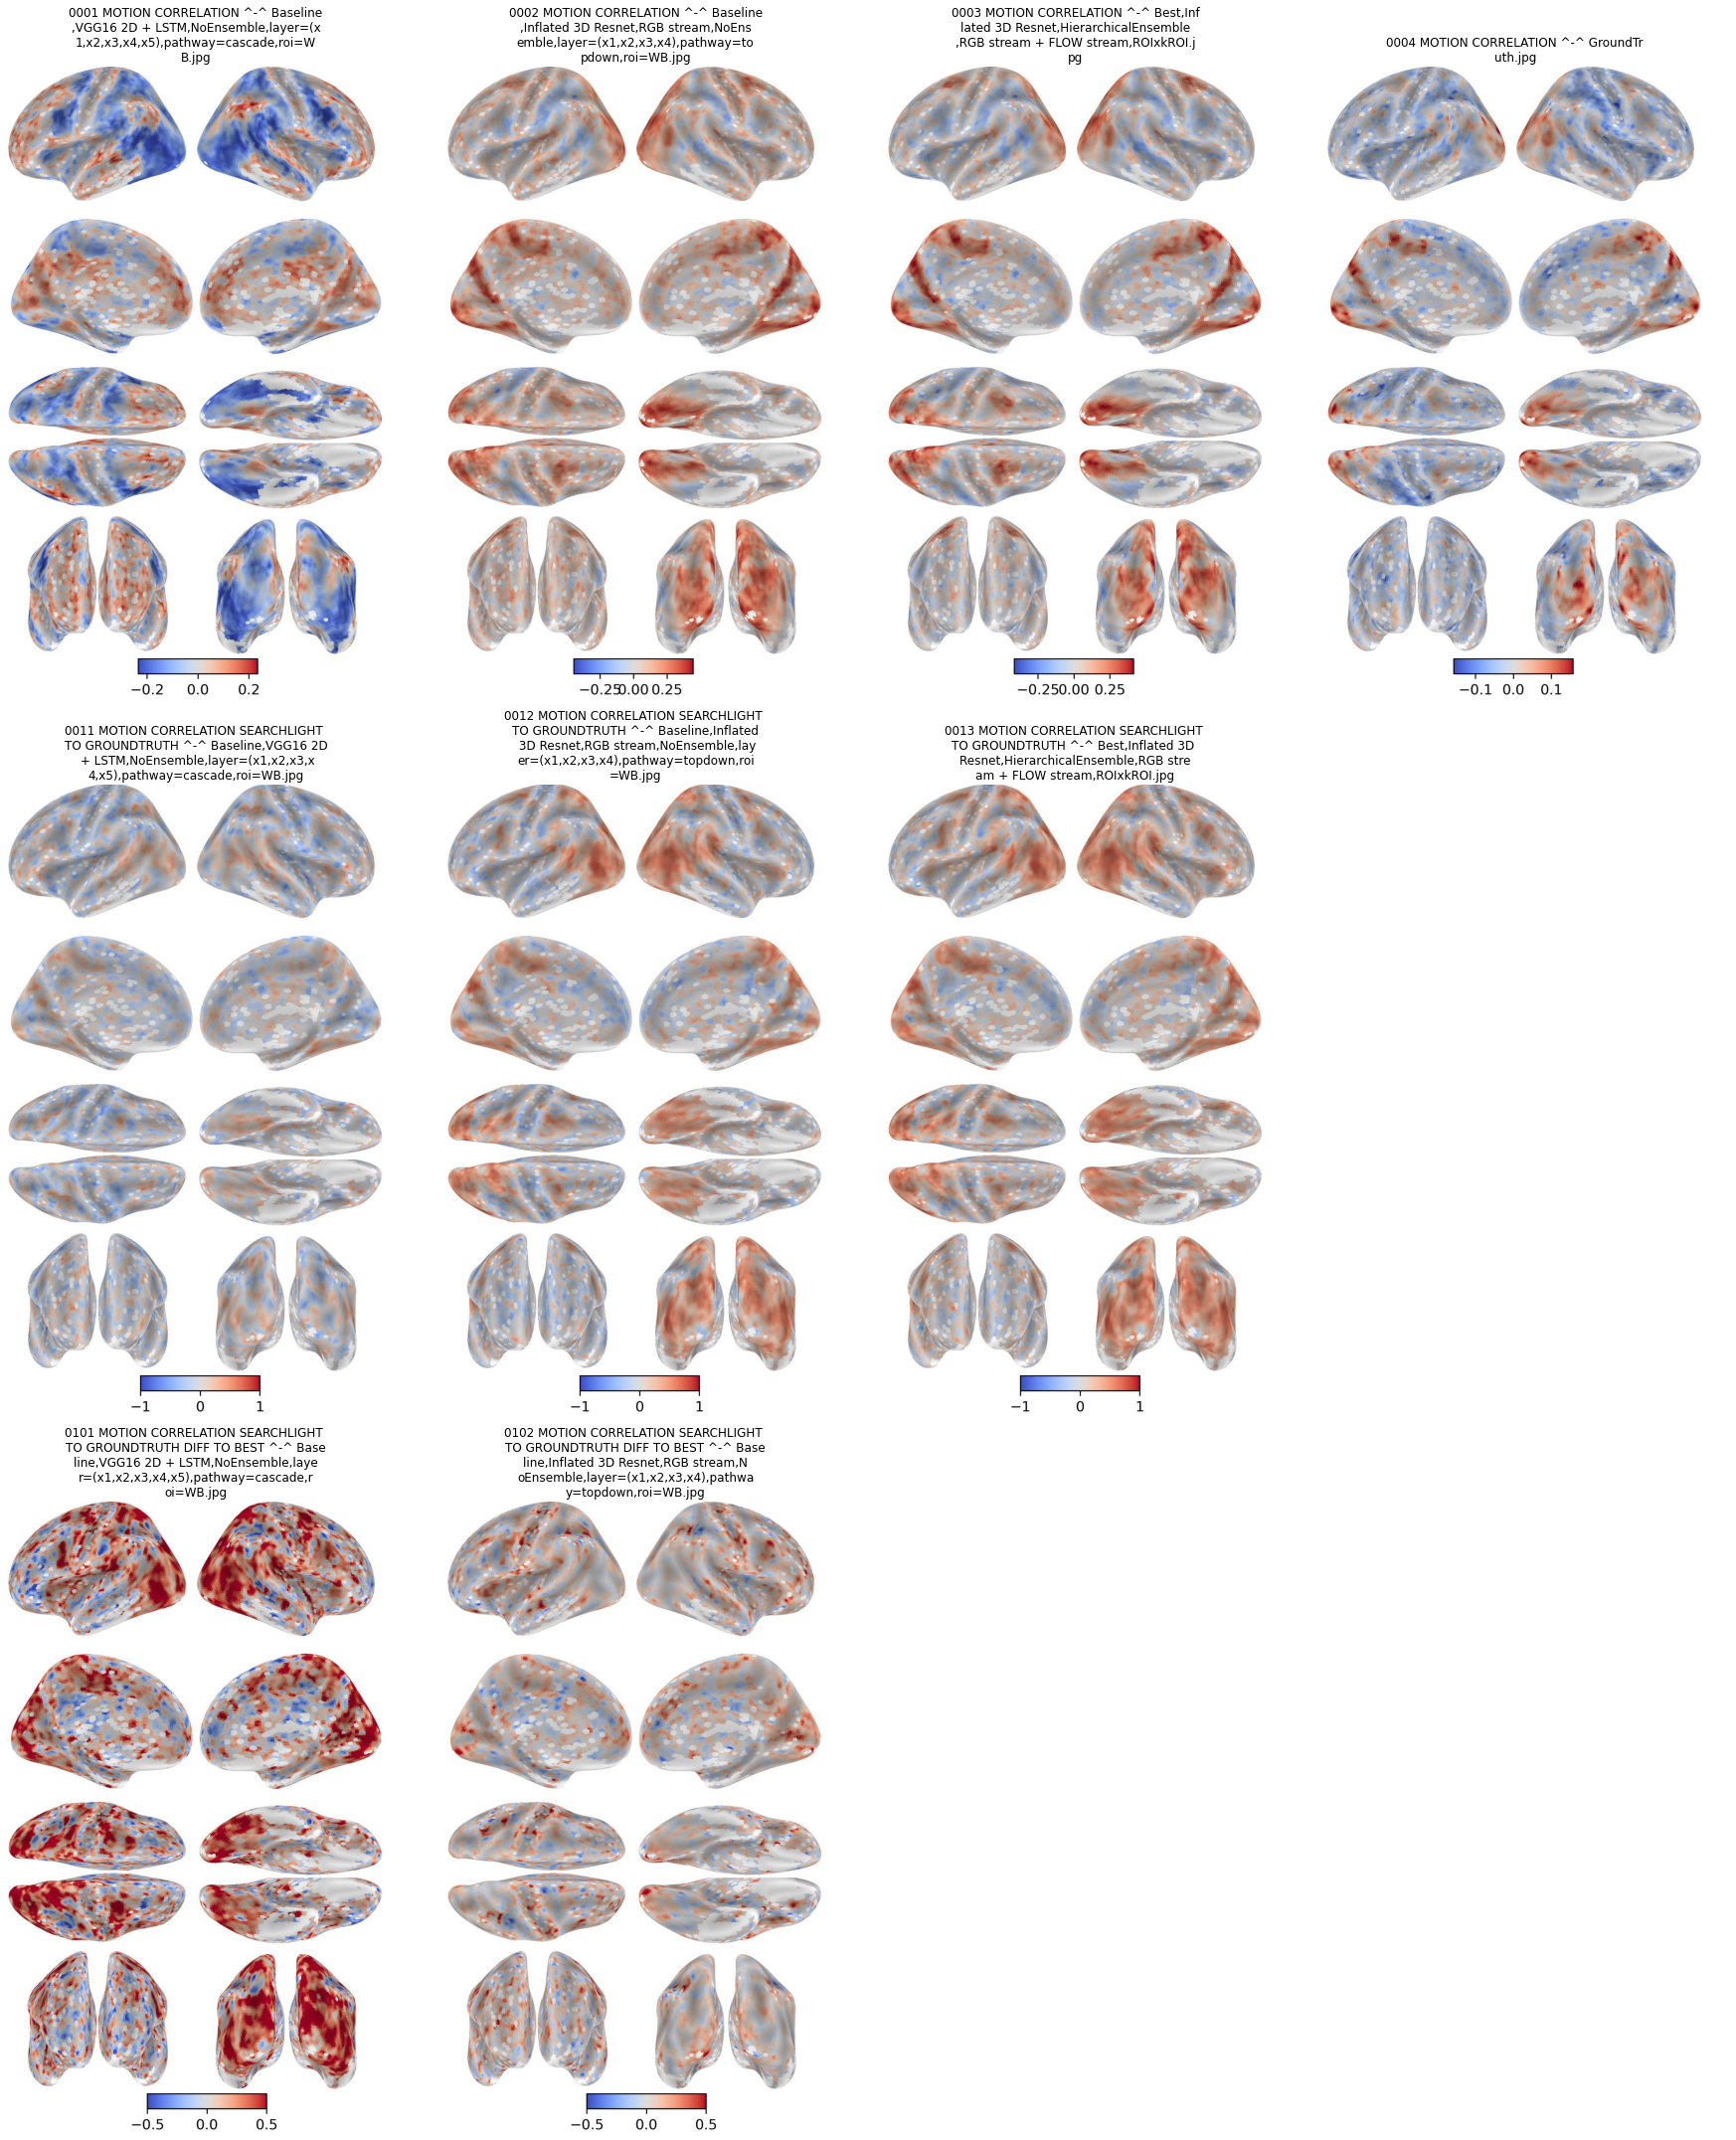

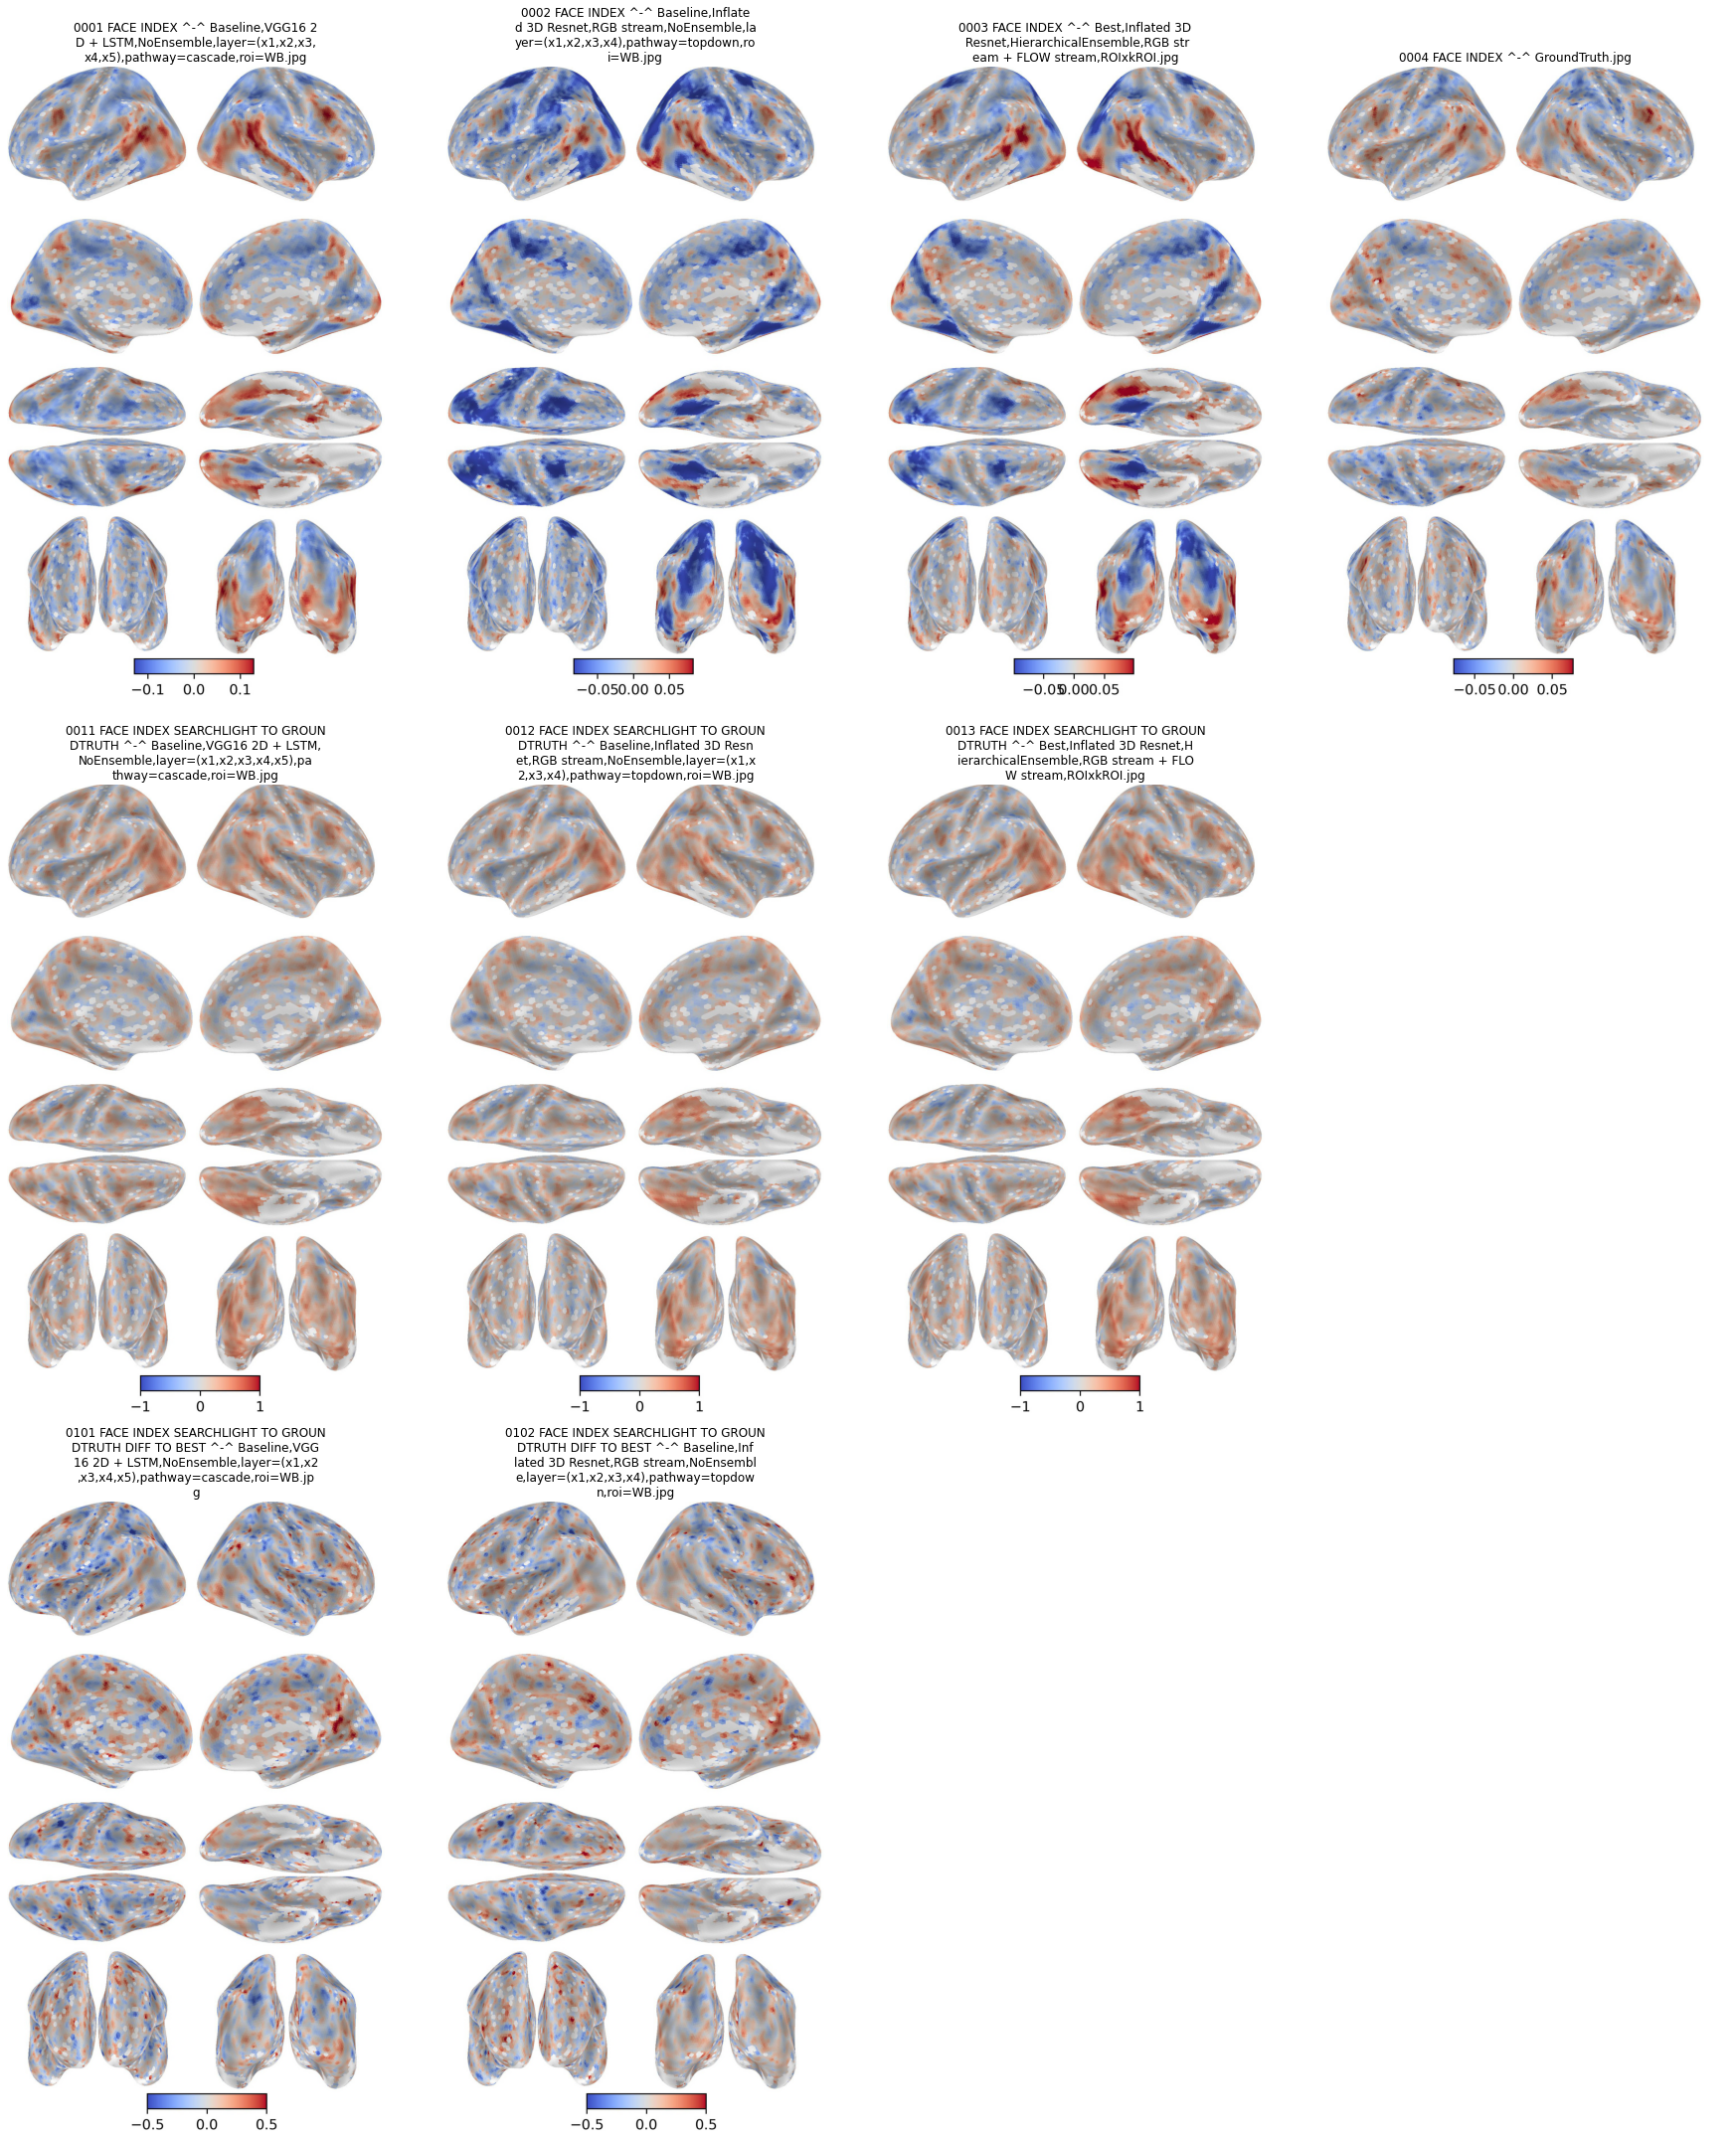

In [18]:
from PIL import Image
import re

fig_dir = Path('./figures')

for fill_text in ['MOTION CORRELATION', 'FACE INDEX']:
    filter_texts = ['PLACEHOLDER ^-^', 'PLACEHOLDER SEARCHLIGHT TO GROUNDTRUTH ^-^',
                    'PLACEHOLDER SEARCHLIGHT TO GROUNDTRUTH DIFF TO BEST ^-^']
    # fill_text = 'MOTION CORRELATION'
    row_paths = []
    for filter_text in filter_texts:
        filter_text = filter_text.replace('PLACEHOLDER', fill_text)
        paths = sorted([path for path in list(fig_dir.iterdir()) if filter_text in path.name])
        row_paths.append(paths)

    ncols = len(row_paths[0])
    nrows = len(row_paths)
    size = 10

    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * size * 0.618, nrows * size))

    axes = axs.flatten()
    for ax in axes:
        ax.axis('off')

    for i, paths in enumerate(row_paths):
        for j, path in enumerate(paths):
            ax = axs[i, j] if nrows > 1 else axs[j]
            ax.imshow(Image.open(path))

            # insert \n each n characters
            title = re.sub("(.{36})", "\\1\n", path.name, 0, re.DOTALL)
            ax.set_title(title)

    plt.tight_layout()
    plt.savefig(fig_dir.joinpath(Path(f'subplots {fill_text}.pdf')))
    plt.show()